In [1]:
# 런타임 -> 런타임 유형변경 -> 하드웨어 가속도 TPU변경
%tensorflow_version 2.x
#런타임 -> 런타임 다시시작

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import natsort
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.9.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading

In [4]:
Norm_data = np.loadtxt("drive/MyDrive/Hail_yeongmin/data/CCD_feature/norm_R21D.csv",  delimiter=',')
#Norm_data_label = np.loadtxt("drive/MyDrive/Hail_yeongmin/data/CCD_feature/normal_labeled_X3D.csv",  delimiter=',')
Anorm_data = np.loadtxt("drive/MyDrive/Hail_yeongmin/data/CCD_feature/crash_R21D.csv", delimiter=',')
#Anorm_data_label = np.loadtxt("drive/MyDrive/Hail_yeongmin/data/CCD_feature/crash_labeled_X3D.csv", delimiter=',')

In [ ]:
#Anorm_data_label = pd.read_csv('drive/MyDrive/Hail_yeongmin/data/CCD_feature/crash_labeled_X3D.csv', header=None)
#Norm_data_label = pd.read_csv('drive/MyDrive/Hail_yeongmin/data/CCD_feature/normal_labeled_X3D.csv', header=None)

In [ ]:
label_test = []
label_train = []

for i in range(9000):
  label_train.append(Norm_data_label[0][i])

for i in range(2025):
  label_test.append(Anorm_data_label[0][i])

In [ ]:
print('Normal: ',len(Norm_data))
print('Crash: ',len(Anorm_data))

Normal:  9000
Crash:  2025


### Train/Test data making

Normal = 0
Anormal = 1

In [6]:
# Train data생성
X,Y = [],[]
train_label = []
for i in range(0, 8000):
  X.append(Norm_data[i])
  Y.append(0) # normal label: 0
  #train_label.append(Norm_data_label[i])
x_train = np.array(X)
y_train = Y

# Test_0생성
X_0, Y_0 = [], []
for i in range(8000, 9000):
  X_0.append(Norm_data[i])
  Y_0.append(0) # normal label: 0
x_train0 = np.array(X_0)
y_train0 = Y_0

# Test data생성
X_test, Y_test = [], []
test_label = []
for i in range(935):
  X_test.append(Norm_data[i])
  Y_test.append(0)
  #test_label.append(label_train[i])

for i in range(65):
  X_test.append(Anorm_data[i])
  Y_test.append(1)
  #test_label.append(label_test[i])
x_test = np.array(X_test)
y_test = Y_test

In [7]:
print("Datasets_train_shape: ", x_train.shape)
print("Datasets_test_shape: ", x_test.shape)

Datasets_train_shape:  (8000, 512)
Datasets_test_shape:  (1000, 512)


In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split

print(tf.__version__)     # 텐서플로우 버전확인 (colab의 기본버전은 1.15.0) --> 2.0 변경 "%tensorflow_version 2.x"
print(keras.__version__)

2.9.2
2.9.0


In [9]:
def AE():
    ## Encoder 구간
    model = tf.keras.Sequential()
    model.add(Dense(256, input_shape=(512,)))  # Input layer + Hidden layer1
    model.add(Activation('relu'))   

    model.add(Dense(128))                       # Hidden layer4
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Activation('relu'))               # Hidden layer5

    model.add(Dense(3))                         # Hidden layer6
    model.add(Activation('relu'))

    ## Decoder 구간
    model.add(Dense(3))                        # Hidden layer6
    model.add(Activation('relu'))

    model.add(Dense(3))                         # Hidden layer5
    model.add(Activation('relu'))

    model.add(Dense(128))                      # Hidden layer4
    model.add(Activation('relu'))

    model.add(Dense(256))                       # Hidden layer3
    model.add(Activation('relu'))

    model.add(Dense(512))                       # Hidden layer2
    model.add(Activation('softmax'))

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1

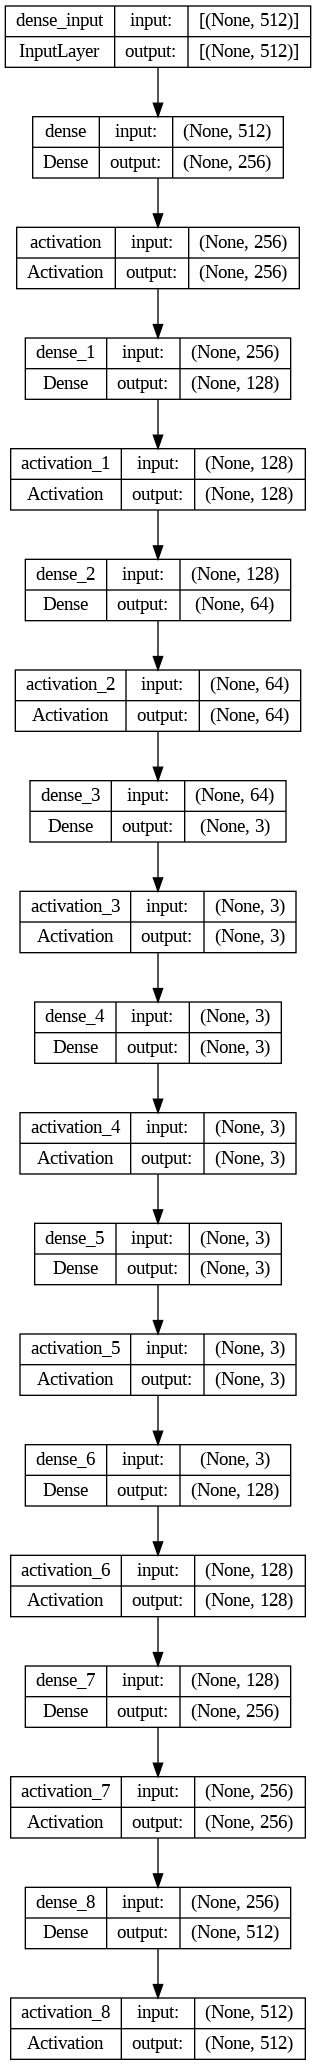

In [10]:
model = AE()
model.summary()
# 위에서 정한 모델을 그림으로(plot) 보여줌
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Model Training

In [11]:

# 모델 구조 확정하고 컴파일 진행
model.compile(loss='MSE',                   # MSE : mean square error
              optimizer='adam',                 
              metrics=[ 'mae' ])            # MAE : mean absolute  error


# model.fit을 써서 학습. 학습과정을 history에 저장
history = model.fit(x_train, x_train,
                    batch_size=100,
                    epochs=100,
                    validation_data=(x_test, x_test),
                    shuffle=True)

Epoch 1/100
80/80 [==============================] - 2s 12ms/step - loss: 1.0594 - mae: 0.8163 - val_loss: 1.0549 - val_mae: 0.8159
Epoch 2/100
80/80 [==============================] - 1s 10ms/step - loss: 1.0562 - mae: 0.8163 - val_loss: 1.0547 - val_mae: 0.8158
Epoch 3/100
80/80 [==============================] - 1s 10ms/step - loss: 1.0559 - mae: 0.8163 - val_loss: 1.0543 - val_mae: 0.8158
Epoch 4/100
80/80 [==============================] - 1s 10ms/step - loss: 1.0556 - mae: 0.8163 - val_loss: 1.0540 - val_mae: 0.8158
Epoch 5/100
80/80 [==============================] - 1s 10ms/step - loss: 1.0554 - mae: 0.8163 - val_loss: 1.0538 - val_mae: 0.8158
Epoch 6/100
80/80 [==============================] - 1s 10ms/step - loss: 1.0552 - mae: 0.8163 - val_loss: 1.0536 - val_mae: 0.8158
Epoch 7/100
80/80 [==============================] - 1s 10ms/step - loss: 1.0550 - mae: 0.8163 - val_loss: 1.0534 - val_mae: 0.8158
Epoch 8/100
80/80 [==============================] - 1s 10ms/step - loss: 1.

## Learning curve

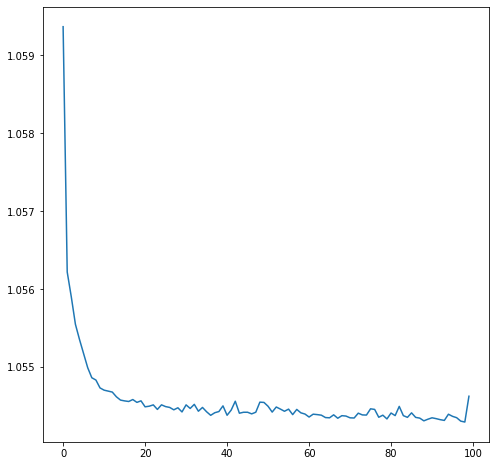

In [12]:
loss = history.history['loss']
plt.figure(figsize=(8, 8))
plt.plot(loss, label = 'Training Losss')
plt.show()

## MSE function

In [13]:
def MSE(p, q):
  return np.mean((p - q)**2)

In [14]:
test_score = model.evaluate(x_train0, x_train0, verbose=0)
prediction = model.predict(x_train0)

32/32 [==============================] - 0s 2ms/step


## 0 이미지로만 구성된 test dataset을 활용하여 MSE 값 측정 + IQR

In [15]:
MSE_loss = []
for i in range(len(x_test)):
  MSE_loss.append(MSE(x_train0[i], prediction[i]))


print("MSE mean: ", np.mean(MSE_loss))
print("MSE variance: ", np.var(MSE_loss))
print("MSE standard deviation: ", np.std(MSE_loss))
mean_mse = np.mean(MSE_loss)
mean_lower_mse, mean_upper_mse = mean_mse - np.std(MSE_loss), mean_mse + np.std(MSE_loss)
print("mean_lower: ", mean_lower_mse)
print("mean_upper: ", mean_upper_mse)
print("MSE min: ", np.min(MSE_loss))
print("\n")

# IQR 계산
q25_mse = np.quantile(MSE_loss, 0.25)
q75_mse = np.quantile(MSE_loss, 0.75)
iqr_mse = q75_mse - q25_mse

cut_off_mse = iqr_mse*1.5
lower_mse, upper_mse = q25_mse - cut_off_mse, q75_mse + cut_off_mse
print("IQR: ", iqr_mse)
print("Lower: ", lower_mse)
print("Upper: ", upper_mse)
print("\n")                        

MSE mean:  1.0672766532404157
MSE variance:  0.04922094384659555
MSE standard deviation:  0.22185793618123187
mean_lower:  0.8454187170591838
mean_upper:  1.2891345894216475
MSE min:  0.1004968691275366


IQR:  0.2867025007105055
Lower:  0.4882134667978397
Upper:  1.6350234696398618




## Loss function: MSE

In [16]:
outlier_score = model.evaluate(x_test, x_test, verbose=0) # loss 값 결과 확인

sample_size = len(x_test)                     # 보여줄 sample 갯수 설정
prediction3 = model.predict(x_test)      # test 데이터로 이미지 복원(predict 함수 사용)

# Dataframe에 저장할 list생성
Result = []

# mixed dataset내 각각의 data point마다 KLD loss를 구한다
MSE_data = []
for i in range(sample_size):
  MSE_data.append(MSE(x_test[i], prediction3[i]))

# 위에서 구한 KLD mean의 lower, upper에 따라 outlier detection 수행
for i in range(sample_size):
  if MSE_data[i] < mean_upper_mse and MSE_data[i] > mean_lower_mse:
    Result.append(0)
  else:
    Result.append(1)

# Confusion matrix
y_true = y_test
y_pred = Result
confusion_matrix(y_true, y_pred, labels=[1,0])

# 분류 성능 평가
print("Acc: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred, pos_label=1))
print("Recall: ", recall_score(y_true, y_pred, pos_label=1))
print("F1 score: ", f1_score(y_true, y_pred, pos_label=1))

# ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
print("AUROC: ", auc(fpr, tpr))
print("AUPRC: ", average_precision_score(y_true, y_pred))
print("\n")

count_TP, count_TN, count_FN, count_FP = 0, 0, 0, 0
for i in range(len(y_pred)):
  if y_true[i] == 1 and y_pred[i] == 1:
    count_TP += 1
  elif y_true[i] == 1 and y_pred[i] == 0:
    count_FN += 1
  elif y_true[i] == 0 and y_pred[i] == 0:
    count_TN += 1
  else:
    count_FP += 1

print("사고를 사고로 예측(TP): ", count_TP)
print("사고를 정상으로 예측(FN): ", count_FN)
print("정상을 정상으로 예측(TN): ", count_TN)
print("정상을 사고로 예측(FP): ", count_FP)

32/32 [==============================] - 0s 2ms/step
Acc:  0.69
Precision:  0.07017543859649122
Recall:  0.3076923076923077
F1 score:  0.11428571428571428
AUROC:  0.5121349238996298
AUPRC:  0.06659244264507422


사고를 사고로 예측(TP):  20
사고를 정상으로 예측(FN):  45
정상을 정상으로 예측(TN):  670
정상을 사고로 예측(FP):  265


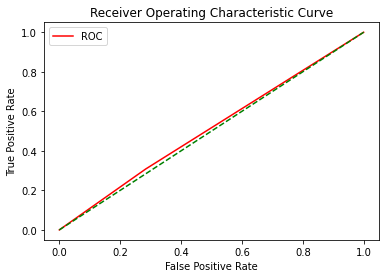

In [17]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

## Loss function: MSE + IQR

In [18]:
outlier_score = model.evaluate(x_test, x_test, verbose=0) # loss 값 결과 확인

sample_size = len(x_test)                     # 보여줄 sample 갯수 설정
prediction3 = model.predict(x_test)      # test 데이터로 이미지 복원(predict 함수 사용)

# Dataframe에 저장할 list생성
Result = []

# mixed dataset내 각각의 data point마다 KLD loss를 구한다
MSE_data = []
for i in range(sample_size):

  MSE_data.append(MSE(x_test[i], prediction3[i]))

# 위에서 구한 KLD mean의 lower, upper에 따라 outlier detection 수행
for i in range(sample_size):
  if MSE_data[i] < upper_mse and MSE_data[i] > lower_mse:
    Result.append(1)
  else:
    Result.append(0)

#print("--------------------------------------------------------\n")

# Confusion matrix
y_true = y_test
y_pred = Result
confusion_matrix(y_true, y_pred, labels=[1,0])

# 분류 성능 평가
print("Acc: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred, pos_label=1))
print("Recall: ", recall_score(y_true, y_pred, pos_label=1))
print("F1 score: ", f1_score(y_true, y_pred, pos_label=1))

# ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
print("AUROC: ", auc(fpr, tpr))
print("AUPRC: ", average_precision_score(y_true, y_pred))
print("\n")

count_TP, count_TN, count_FN, count_FP = 0, 0, 0, 0
for i in range(len(y_pred)):
  if y_true[i] == 1 and y_pred[i] == 1:
    count_TP += 1
  elif y_true[i] == 1 and y_pred[i] == 0:
    count_FN += 1
  elif y_true[i] == 0 and y_pred[i] == 0:
    count_TN += 1
  else:
    count_FP += 1

print("정상을 정상으로 예측: ", count_TP)
print("정상을 사고로 예측: ", count_FN)
print("사고를 사고로 예측: ", count_TN)
print("사고를 정상으로 예측: ", count_FP)

32/32 [==============================] - 0s 3ms/step
Acc:  0.077
Precision:  0.06402439024390244
Recall:  0.9692307692307692
F1 score:  0.12011439466158245
AUROC:  0.4921020156314274
AUPRC:  0.06405440900562852


정상을 정상으로 예측:  63
정상을 사고로 예측:  2
사고를 사고로 예측:  14
사고를 정상으로 예측:  921


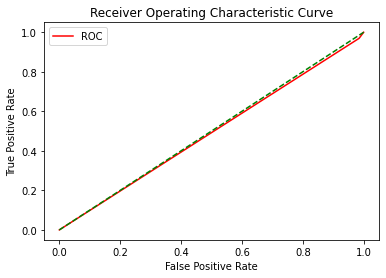

In [19]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

282/282 [==============================] - 1s 2ms/step
Normal Metric
        Normal_mse
count  9000.000000
mean      1.054244
std       0.219020
min       0.098869
25%       0.909418
50%       1.040943
75%       1.185673
max       2.084160


32/32 [==============================] - 0s 2ms/step
Anomaly Metric
       Anomaly_mse
count  1000.000000
mean      1.052943
std       0.216600
min       0.213314
25%       0.904170
50%       1.041071
75%       1.183944
max       1.800437




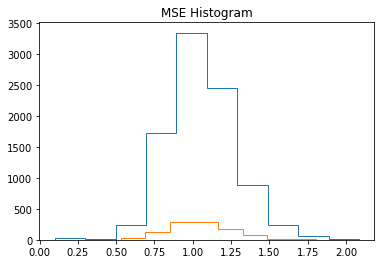

In [20]:
import pandas as pd # pandas 라이브러리

# Normal data (data_3000)
Nom_data = np.concatenate((x_test, x_train), axis = 0)
Nom_pred = model.predict(Nom_data) # AE 이미지 결과값 
Nom_pred_mse = np.mean(np.power(Nom_data - Nom_pred, 2), axis=1) # input - output 이미지간의 MSE 구하기

# 기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 방법
print('Normal Metric')
Nom_pred_mse_df = pd.DataFrame({'Normal_mse':Nom_pred_mse})
print(Nom_pred_mse_df.describe())

print('\n')

# Abnormal data (data_1000)
ANom_pred = model.predict(x_test) # AE 이미지 결과값 
ANom_pred_mse = np.mean(np.power(x_test - ANom_pred, 2), axis=1) # input - output 이미지간의 MSE 구하기

# 기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 방법
print('Anomaly Metric')
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse':ANom_pred_mse})
print(ANom_pred_mse_df.describe())

# 히스토그램 그리기
print('\n')
plt.figure()
plt.title('MSE Histogram') # 그림 이름 설정 
plt.hist(Nom_pred_mse, bins=10, facecolor='blue', histtype='step') #히스토그램 함수, bins:데이터를 범주화 하는 기준
plt.hist(ANom_pred_mse, bins=10, facecolor='red', histtype='step') #히스토그램 함수, bins:데이터를 범주화 하는 기준
plt.show()